In [2]:
from scripts.ising_simulation import IsingSimulation
import numpy as np
from joblib import Parallel, delayed
from matplotlib import pyplot as plt
import seaborn as sns
import pickle

In [3]:

def calc_susceptibility(beta, J, n_rois, eq_steps=300, mc_steps=200):
    sim = IsingSimulation(n_rois, beta, coupling_mat = True, J=J)
    energy_eq = []
    mag_eq = []
    for i in range(eq_steps):
        sim.step()
        energy_eq.append(sim.calcEnergy())
        mag_eq.append(sim.calcMag())
    mag = []
    mag_squared = []
    energy = []
    energy_squared = []
    chi = []
    states = []
    for i in range(mc_steps):
        s = sim.step()
        states.append(s)
        mag.append(sim.calcMag())
        energy.append(sim.calcEnergy())
        mag_squared.append(mag[-1]**2)
        energy_squared.append(energy[-1]**2)
        c = (np.mean(mag_squared) - np.mean(mag)**2) *beta / (n_rois * n_rois) 
        chi.append(c)
    return chi, mag, energy, energy_eq, mag_eq, states
    # return chi

In [4]:
ising_reps = np.load('../data/AAL_reps/ising_NYU.npy')
fc_rep_ut = np.load('../data/AAL_reps/sfc_NYU.npy')
diag = np.load('../data/AAL_reps/diag_NYU.npy')
betas = np.load('../data/AAL_reps/betas_NYU.npy')
n_rois = ising_reps.shape[1]
fc_reps = np.zeros((fc_rep_ut.shape[0], n_rois, n_rois))
for i in range(fc_rep_ut.shape[0]):
    fc_reps[i][np.triu_indices(n_rois)] = fc_rep_ut[i]
    fc_reps[i] = np.triu(fc_reps[i]) + np.tril(fc_reps[i].T, k=-1)

In [5]:
eq_steps, mc_steps = 1000, 2000

In [6]:

chi, mag, energy, energy_eq, mag_eq = calc_susceptibility(0.02, ising_reps[0], n_rois, eq_steps=eq_steps, mc_steps=mc_steps)


KeyboardInterrupt: 

In [7]:
# plt.plot(range(mc_steps), mag, label='mag')
# plt.plot(range(mc_steps), energy, label='energy')
# mag_avg = np.convolve(mag, np.ones(mc_steps)/mc_steps, mode='same')
# print(mag_avg)
# plt.plot(range(mc_steps), mag_avg, label='mag_avg')
eq_steps = 0
mc_steps = 10000
beta_range = np.arange(0.01, 0.25, 0.01)
res = Parallel(n_jobs=6)(delayed(calc_susceptibility)(beta, ising_reps[0], n_rois, eq_steps=eq_steps, mc_steps=mc_steps) for beta in beta_range)
# for beta in beta_range:
#     beta = round(beta, 5)
#     chi, mag, energy, energy_eq, mag_eq = calc_susceptibility(beta, ising_reps[0], n_rois, eq_steps=eq_steps, mc_steps=mc_steps)


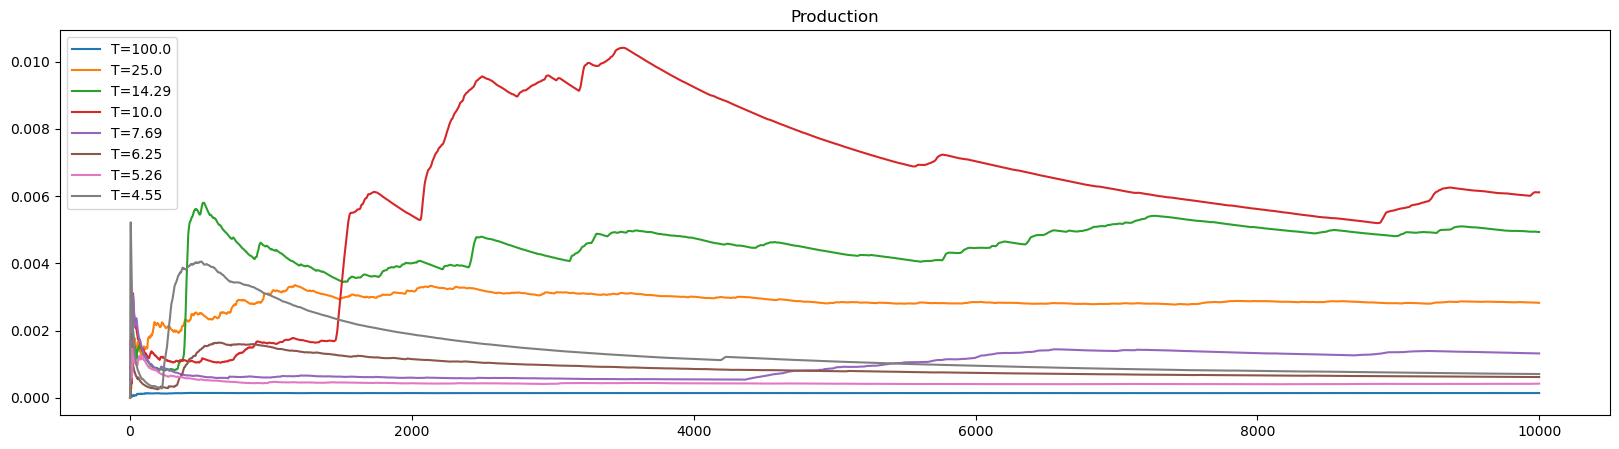

In [25]:
for idx, (chi, mag, energy, energy_eq, mag_eq, states) in enumerate(res):
    if idx%3 == 0:
        plt.plot(range(mc_steps), chi, label='T={}'.format(round(1/beta_range[idx], 2)))
plt.legend()
plt.title('Production')
#increase figure size 
plt.rcParams['figure.figsize'] = [20, 5]
plt.show()


0.16


Text(0, 0.5, 'Susceptibility')

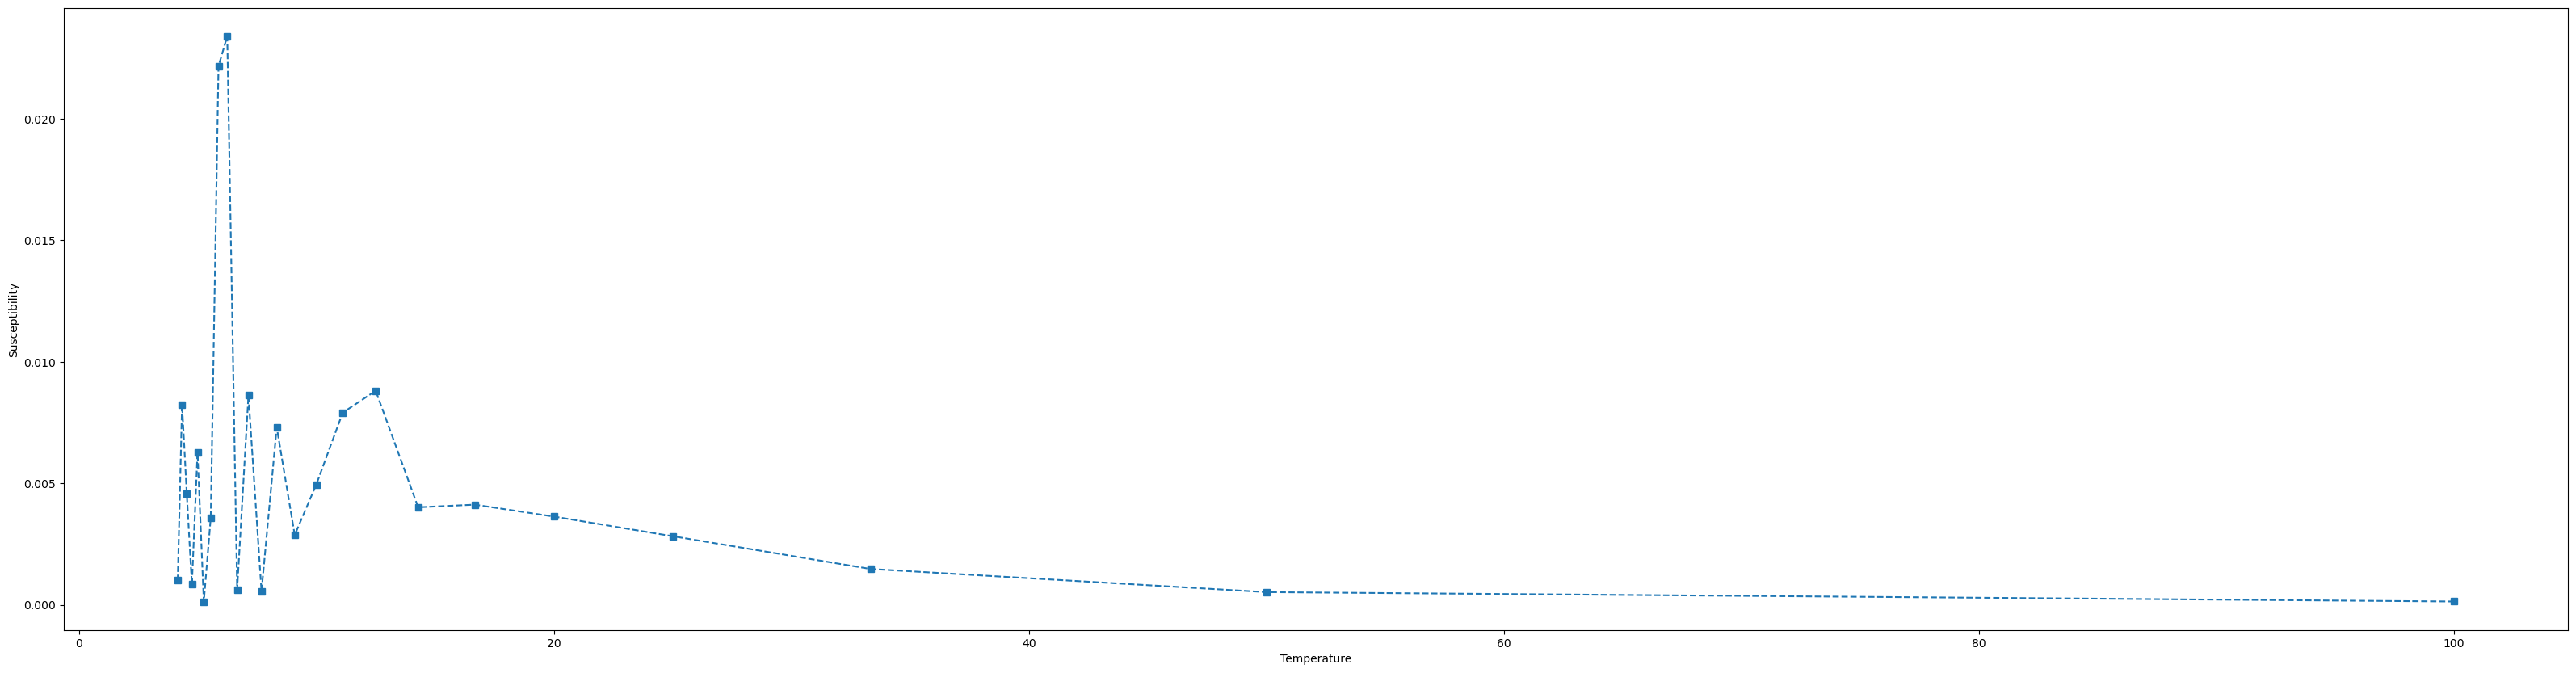

In [50]:
chis = []
for chi, mag, energy, energy_eq, mag_eq, states in res:
    chis.append(chi[-1])
# print(len(chis))
# print(len(beta_range))
i = chis.index(max(chis))
# print(beta_range[i])
plt.plot(1/beta_range, chis,  linestyle='dashed', marker='s')
plt.xlabel("Temperature")
plt.ylabel("Susceptibility")

In [21]:
beta = 0.00001
chi, mag, energy, energy_eq, mag_eq, states = calc_susceptibility(beta, ising_reps[0], n_rois, eq_steps=eq_steps, mc_steps=mc_steps)

In [19]:
pickle.dump(res, open('../data/AAL_reps/ising_susceptibility_NYU.pkl', 'wb'))

In [21]:
chi, mag, energy, _, _, states = res[2]

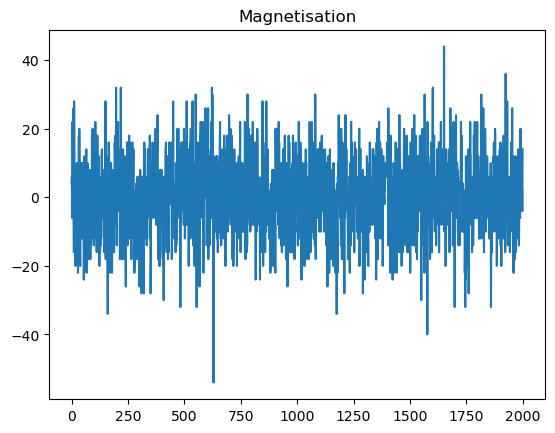

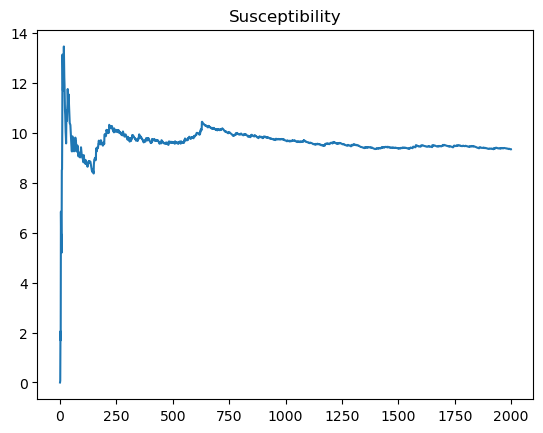

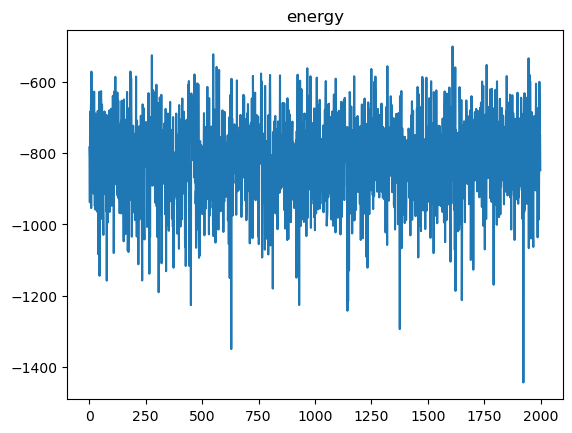

In [16]:
plt.plot(range(len(mag)), mag, label='energy')
plt.title('Magnetisation')
plt.show()

plt.plot(range(len(chi)), chi, label='chi')
plt.title('Susceptibility')
plt.show()


plt.plot(range(len(energy)), energy, label='chi')
plt.title('energy')
plt.show()

(2000, 116)


<AxesSubplot:>

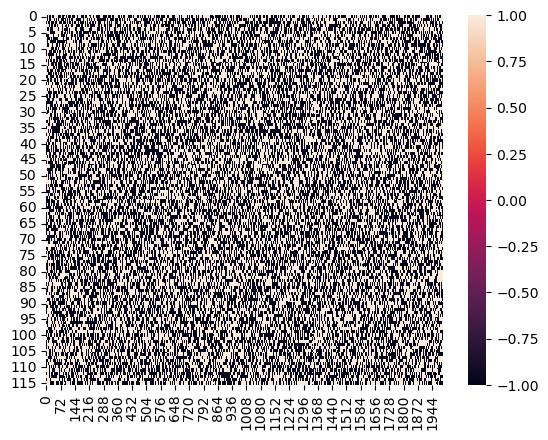

In [22]:
states = np.array(states)
# states = states[::n_rois]
print(states.shape)
sns.heatmap(states.T)

In [48]:
fc_pos = fc_reps[diag == 0]
fc_neg = fc_reps[diag == 1]
ising_pos = ising_reps[diag == 0]
ising_neg = ising_reps[diag == 1]

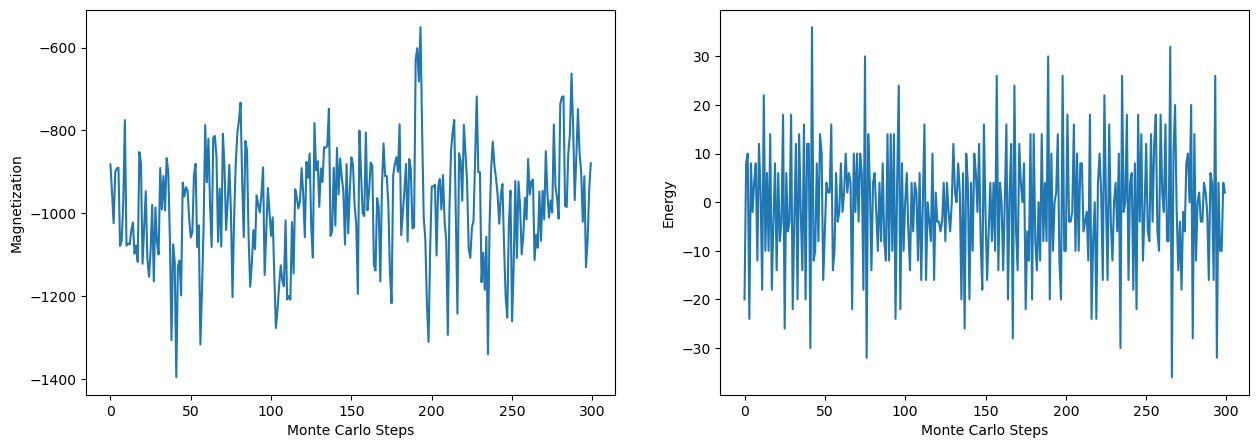

In [41]:
# plot magnetization and energy with proper labels
def plot_mag_energy(mag, energy):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(mag)
    plt.xlabel('Monte Carlo Steps')
    plt.ylabel('Magnetization')
    plt.subplot(1, 2, 2)
    plt.plot(energy)
    plt.xlabel('Monte Carlo Steps')
    plt.ylabel('Energy')
    plt.show()
    return
plot_mag_energy(mag_eq, energy_eq)

In [26]:
# calculate autocorrelation of signal
def autocorrelation(signal):
    return np.correlate(signal, signal, mode='full')[len(signal)-1:]

In [44]:
mag = []
mag_at = []
n = len(beta_range)
for i in range(n):
    mag.append(res[i][1][-5000:])
    mag_at.append(autocorrelation(mag[-1]))

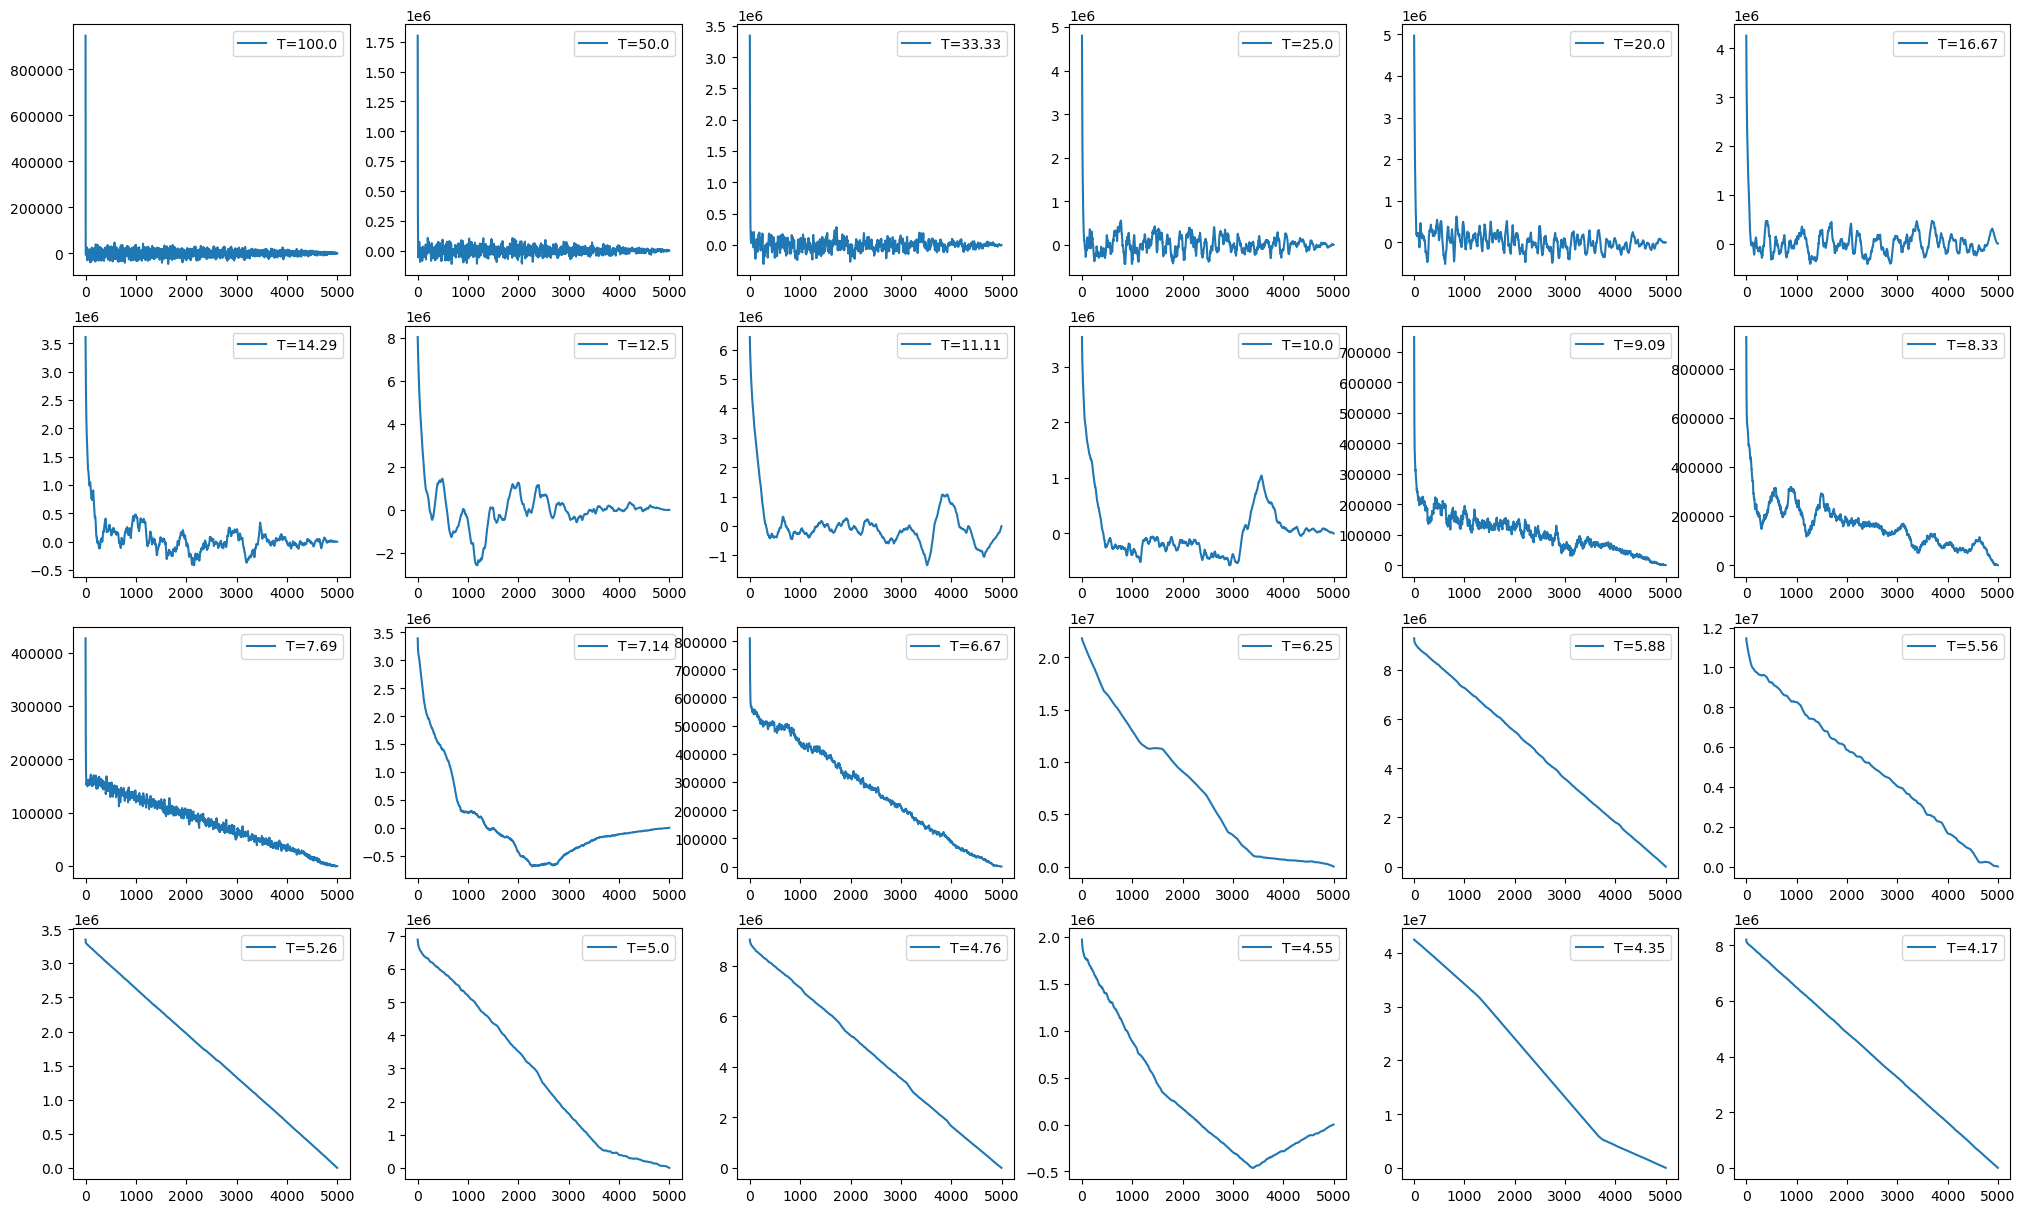

In [45]:
figs, axs = plt.subplots(4, 6, figsize=(15, 5))
for i, beta in enumerate(beta_range):
    # if i%3 == 0: continue
    axs[i//6, i%6].plot(range(len(mag_at[i])), mag_at[i], label='T={}'.format(round(1/beta, 2)))
    axs[i//6, i%6].legend()
#make grid bigger
figs.set_figheight(15)
figs.set_figwidth(25)
plt.show()

In [56]:
def mag_at(J):
    res = calc_susceptibility(beta, J, n_rois, eq_steps=eq_steps, mc_steps=mc_steps)
    return res[1], autocorrelation(res[1][-5000:])

In [57]:
beta = 0.03

res_pos = Parallel(n_jobs=6)(delayed(mag_at)(J) for J in ising_pos[:10])
res_neg = Parallel(n_jobs=6)(delayed(mag_at)(J) for J in ising_neg[:10])

In [61]:
pickle.dump(res_pos, open('mag_at_pos_NYU.pkl', 'wb'))
pickle.dump(res_neg, open('mag_at_neg_NYU.pkl', 'wb'))

In [58]:
mean_mag_at_pos = np.mean(res_pos, axis=0)
mean_mag_at_neg = np.mean(res_neg, axis=0)

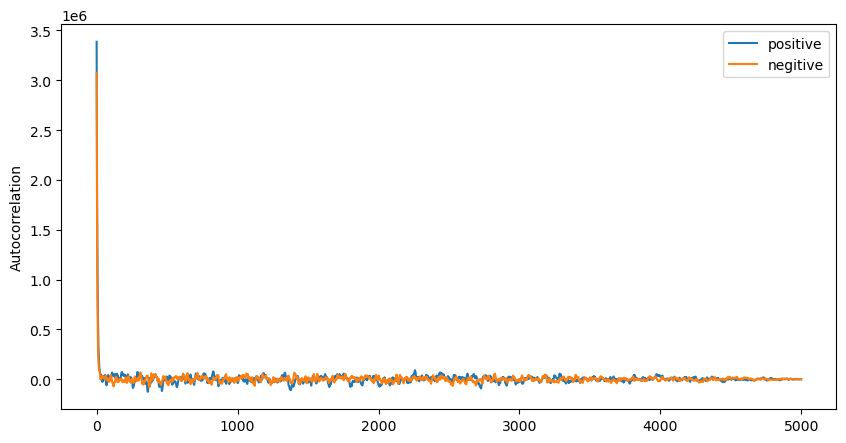

In [60]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.plot(mean_mag_at_pos, label='positive')
plt.plot(mean_mag_at_neg, label='negitive')
plt.ylabel('Autocorrelation')
plt.legend()
plt.show()